### ordination to pull out fractions containing labeled OTUs

In [1]:
from pandas import DataFrame, get_dummies
import statsmodels.api as sm
from statsmodels.sandbox.regression.try_catdata import cat2dummy
from IPython.display import FileLink

In [2]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%R
library(phyloseq)
library(vegan)
library(ggplot2)
library(foreach)
library(doParallel)
library(plyr)
library(gridExtra)
library(RColorBrewer)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0
Use suppressPackageStartupMessages to eliminate package startup messages.
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


In [4]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.all = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS"))& (physeq.md$Day %in% c(30)) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.all.snorm = transform_sample_counts(physeq.all, function(x) x/sum(x))
physeq.all.thresh = filter_taxa(physeq.all.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.all)
print(physeq.all.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1220 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1220 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1220 tips and 1219 internal nodes ]


### Calculate pairwise weighted unifrac distances between samples.

In [5]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.all.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

###Ordinate using weighted unifrac distances with NMDS.

In [6]:
%%R
nmds = ordinate(physeq.all.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08691032 
Run 1 stress 0.09151752 
Run 2 stress 0.09080877 
Run 3 stress 0.1137131 
Run 4 stress 0.09466884 
Run 5 stress 0.09081093 
Run 6 stress 0.08719261 
... procrustes: rmse 0.005387579  max resid 0.02792278 
Run 7 stress 0.08691047 
... procrustes: rmse 9.997347e-05  max resid 0.0006878614 
*** Solution reached


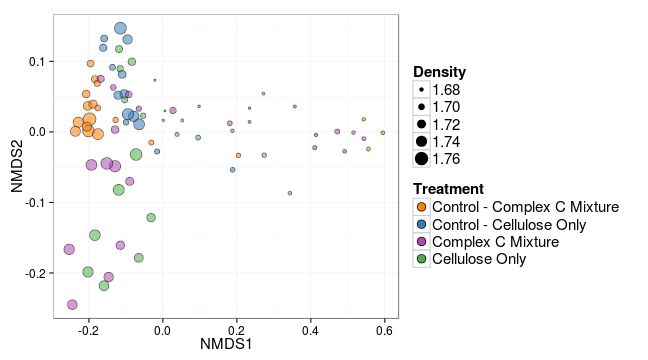

In [25]:
%%R -w 9 -h 5 -u in

colours = c("#ff7f00", "#377eb8", "#ac4aaf", "#4daf4a")

df = plot_ordination(physeq.all.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12CCPS", "12CCSS", "13CCPS", "13CCSS"),
                            labels=c("Control - Complex C Mixture", "Control - Cellulose Only", 
                                     "Complex C Mixture", "Cellulose Only"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
#p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
#p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))
p1 = p1 + theme(axis.title.x = element_text(size=15))
p1 = p1 + theme(axis.title.y = element_text(size=15))
p1 = p1 + theme(axis.text.x = element_text(size=12))
p1 = p1 + theme(axis.text.y = element_text(size=12))
p1 = p1 + theme(legend.title = element_text(size = 15), legend.text = element_text(size = 15))

p1

In [26]:
%%R
pdf("figs/ordination_allD30.pdf", w = 7, h = 6)
grid.arrange(p1, ncol = 1)
dev.off()

png 
  2 


In [27]:
%%R
ggsave("figs/ordination_allD30.png", p1, w = 6, h = 4, units = "in", dpi = 1600)

In [28]:
%%R
ggsave("figs/ordination_allD30.tiff", p1, w = 6, h = 4)

In [29]:
FileLink("figs/ordination_allD30.tiff")

/home/ashley/single_substrate/figs/ordination_allD30.tiff

In [30]:
FileLink("figs/ordination_allD30.png")

/home/ashley/single_substrate/figs/ordination_allD30.png

In [31]:
FileLink("figs/ordination_allD30.pdf")

/home/ashley/single_substrate/figs/ordination_allD30.pdf

In [14]:
%%R
physeq.thresh.heavy = prune_samples(sample_data(physeq.all.thresh)$Density >= 1.725, physeq.all.thresh)

In [15]:
%%R
#convert physeq object to a dataframe for adonis test
df = sample_data(physeq.all.thresh)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
df = data.frame(df)
df

                 X.SampleID BarcodeSequence Day Density   LinkerPrimerSequence
cont.SS.30.10 cont.SS.30.10      TCACTCTGTC  30  1.7417 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.9     13C.SS.30.9      TCACGTGTAC  30  1.7351 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.13   13C.SS.30.13      TCACTGAGAG  30  1.7155 CAGGACTACHVGGGTWTCTAAT
cont.SS.30.27 cont.SS.30.27      TCAGACACAG  30  1.6750 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.7     13C.SS.30.7      TCACGAGTAG  30  1.7428 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.15 cont.PS.30.15      TCACACGAGA  30  1.7122 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.9   cont.PS.30.9      TCAAGCAACG  30  1.7395 CAGGACTACHVGGGTWTCTAAT
cont.SS.30.18 cont.SS.30.18      TCAGAGTGTG  30  1.7100 CAGGACTACHVGGGTWTCTAAT
cont.SS.30.14 cont.SS.30.14      TCACTGTGTG  30  1.7264 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.6     13C.SS.30.6      TCAGCAACGA  30  1.7461 CAGGACTACHVGGGTWTCTAAT
13C.PS.30.23   13C.PS.30.23      TCAACGATGG  30  1.6750 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.7   cont.PS.30.7      TCAACCATCG  30  1.7

In [16]:
%%R
wunif.dist.heavy = distance(physeq.thresh.heavy, method = "unifrac", weighted = TRUE)

In [17]:
%%R
#to test if community composition in Bulk DNA sequencing is different between treatments
adonis.wunif = adonis(wunif.dist ~ Treatment, data = df, permutations = 1000)
adonis.wunif


Call:
adonis(formula = wunif.dist ~ Treatment, data = df, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2  Pr(>F)  
Treatment  3    0.6643 0.221424  2.7179 0.09689 0.01399 *
Residuals 76    6.1917 0.081469         0.90311          
Total     79    6.8559                  1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R
#convert physeq object to a dataframe for adonis test
df2 = sample_data(physeq.thresh.heavy)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
df2 = data.frame(df2)
df2

                 X.SampleID BarcodeSequence Day Density   LinkerPrimerSequence
cont.SS.30.10 cont.SS.30.10      TCACTCTGTC  30  1.7417 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.9     13C.SS.30.9      TCACGTGTAC  30  1.7351 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.7     13C.SS.30.7      TCACGAGTAG  30  1.7428 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.9   cont.PS.30.9      TCAAGCAACG  30  1.7395 CAGGACTACHVGGGTWTCTAAT
cont.SS.30.14 cont.SS.30.14      TCACTGTGTG  30  1.7264 CAGGACTACHVGGGTWTCTAAT
13C.SS.30.6     13C.SS.30.6      TCAGCAACGA  30  1.7461 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.7   cont.PS.30.7      TCAACCATCG  30  1.7526 CAGGACTACHVGGGTWTCTAAT
13C.PS.30.7     13C.PS.30.7      TCAACCATGC  30  1.7439 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.10 cont.PS.30.10      TCAAGCTTCG  30  1.7362 CAGGACTACHVGGGTWTCTAAT
13C.PS.30.8     13C.PS.30.8      TCACGACAAG  30  1.7406 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.8   cont.PS.30.8      TCAACGATCC  30  1.7461 CAGGACTACHVGGGTWTCTAAT
cont.PS.30.12 cont.PS.30.12      TCAAGCGGTA  30  1.7

In [19]:
%%R
#to test if community composition in Bulk DNA sequencing is different between treatments
adonis.wunif.heavy = adonis(wunif.dist.heavy ~ Treatment, data = df2, permutations = 1000)
adonis.wunif.heavy


Call:
adonis(formula = wunif.dist.heavy ~ Treatment, data = df2, permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Treatment  3   0.49418 0.16473  13.382 0.65655 0.000999 ***
Residuals 21   0.25851 0.01231         0.34345             
Total     24   0.75269                 1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
